In [69]:
# import a few packages for the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, date, time

In [70]:
# switch off some warning messages
pd.options.mode.chained_assignment = None

In [71]:
path = '/Users/anatolyabramovich/Desktop/Documents/Study/Kaggle/house_pricing/train.csv'
data = pd.read_csv(path, index_col='Id')

# Exploratory Data Analysis (EDA)
Let's start with EDA to understand what data  we have

In [72]:
# just an additional column which will be needed when merging dataframes 
data['ind'] = list(range(1,len(data)+1))

In [73]:
# the first look on the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### 1. Find and drop columns with a lot of missing data

The 0.25 threshold was chosen here, in other words columns that contained more than 75% missing data were dropped.
To handle this problem a special function "cleaning_algorithm" was written.

In [74]:
#function to compute null spaces in the columns and delete a column which is not satisfied conditions
def cleaning_algorithm(df, percent=0.25):
    def checking_amount_of_null_per_column ():
        list_suspected = pd.Series(df.columns.to_list())
        trouble_list = []
        trouble_score = []
        for i in list_suspected:
            amount_of_na = df[i].isna().sum()
            count_percentages_of_na = amount_of_na/len(df.index)
            if count_percentages_of_na >= percent:
                trouble_list.append(i)
                trouble_score.append(count_percentages_of_na)
        return pd.Series(trouble_list, trouble_score)
    print('initial amount of columns: ', len(df.columns))
    print('\n')
    a = checking_amount_of_null_per_column()
    a = pd.DataFrame({'column_name':a.values, '% of null values':a.index})
    df = df.drop(list(a['column_name']), axis=1)
    print('list of columns were dropped:', a, sep='\n')
    print('\n')
    print('amount of columns after cleaning: ', len(df.columns))
    return df

In [75]:
data = cleaning_algorithm(data)

initial amount of columns:  81


list of columns were dropped:
   column_name  % of null values
0        Alley          0.937671
1  FireplaceQu          0.472603
2       PoolQC          0.995205
3        Fence          0.807534
4  MiscFeature          0.963014


amount of columns after cleaning:  76


### 2. Separate initial data into two dataframes: numerical and categorical

Since categorical data and numerical data should be treated differently initial base was separated into the two dataframes: data_categorical and data_numeric. Let's start with the first one.

### 2.1 Categorical data frame

In [76]:
# creating datetime column
data.rename(columns={'YrSold':'Year', 'MoSold':'Month'}, inplace=True)
data['Day']=1
data['YM_sold'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [77]:
data['MSSubClass'] = data['MSSubClass'].astype('category')

In [78]:
data_categorical = data.select_dtypes(include=['object', 'category'])

In [79]:
data_categorical['ind'] = list(range(1,1461))

In [80]:
data_categorical.loc[:,'CentralAir'] = data_categorical.CentralAir.map({'Y':1, 'N':0})

In [81]:
data_categorical = data_categorical.astype('category')

####   ================================  Decoding attitude measure data into numeric. Beginning   ================================

In [82]:
recoding = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']

In [83]:
data_categorical[recoding].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ExterQual    1460 non-null   category
 1   ExterCond    1460 non-null   category
 2   BsmtQual     1423 non-null   category
 3   BsmtCond     1423 non-null   category
 4   HeatingQC    1460 non-null   category
 5   KitchenQual  1460 non-null   category
 6   GarageQual   1379 non-null   category
 7   GarageCond   1379 non-null   category
dtypes: category(8)
memory usage: 24.3 KB


In [84]:
# decoding letters to numbers
data_categorical.loc[:,recoding] = data_categorical.loc[:,recoding].apply(lambda x: x.map({'TA':3, 'Gd':4, 'Fa':2, 'Po':1, 'Ex':5}))

In [85]:
# fill na with the most common value in a column
data_categorical.loc[:,recoding] = data_categorical.loc[:,recoding].apply(lambda x:x.fillna(x.value_counts().index[0]))

In [86]:
# change type of data to numeric
data_categorical.loc[:,recoding] = data_categorical.loc[:,recoding].apply(lambda x: x.astype('int64'))

In [87]:
# drop columns from the categorical set and add it to the full base
data[recoding] = data_categorical[recoding]
data_categorical = data_categorical.drop(recoding, axis=1)

In [88]:
data[recoding].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ExterQual    1460 non-null   int64
 1   ExterCond    1460 non-null   int64
 2   BsmtQual     1460 non-null   int64
 3   BsmtCond     1460 non-null   int64
 4   HeatingQC    1460 non-null   int64
 5   KitchenQual  1460 non-null   int64
 6   GarageQual   1460 non-null   int64
 7   GarageCond   1460 non-null   int64
dtypes: int64(8)
memory usage: 102.7 KB


#### ================================  Decoding attitude measure data into numeric. End  ================================

In [89]:
#and the last one - get dummies features
data_categorical = pd.get_dummies(data_categorical, columns=data_categorical.drop('ind', axis=1).columns)

### 2.2 NUMERIC

In [90]:
data_numeric = data.select_dtypes(include=['int64','float64'])

In [91]:
#let's watch what we have
data_numeric.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Month,Year,SalePrice,ind,Day
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.00000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0
mean,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,3.39589,3.083562,3.565068,...,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,730.500000,1.0
std,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,0.57428,0.351054,0.678071,...,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,421.610009,0.0
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.00000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,1.000000,1.0
25%,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,3.00000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,365.750000,1.0
50%,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,3.00000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,730.500000,1.0
75%,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,4.00000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,1095.250000,1.0
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5.00000,5.000000,5.000000,...,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,1460.000000,1.0


In [92]:
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1201 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   OverallQual    1460 non-null   int64  
 3   OverallCond    1460 non-null   int64  
 4   YearBuilt      1460 non-null   int64  
 5   YearRemodAdd   1460 non-null   int64  
 6   MasVnrArea     1452 non-null   float64
 7   ExterQual      1460 non-null   int64  
 8   ExterCond      1460 non-null   int64  
 9   BsmtQual       1460 non-null   int64  
 10  BsmtCond       1460 non-null   int64  
 11  BsmtFinSF1     1460 non-null   int64  
 12  BsmtFinSF2     1460 non-null   int64  
 13  BsmtUnfSF      1460 non-null   int64  
 14  TotalBsmtSF    1460 non-null   int64  
 15  HeatingQC      1460 non-null   int64  
 16  1stFlrSF       1460 non-null   int64  
 17  2ndFlrSF       1460 non-null   int64  
 18  LowQualF

In [93]:
#Fillin missing data
data_numeric.LotFrontage.fillna(value=data_numeric.LotFrontage.mean(), inplace=True)

In [94]:
data_numeric.GarageYrBlt.fillna(value=data_numeric.YearBuilt.mean(), inplace=True)

### 2.2.1 Clearning outliers
There are a lot of numeric data and it's natural to check whether outliers occur in the data set.

#### Visual checking
Let's start with the visual checking. Boxplot is the most handy tool for visual outliers checking.

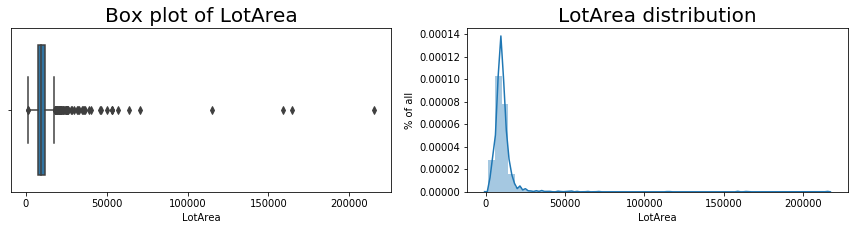

In [95]:
# checking outliers in 'LotArea' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric.LotArea)
plt.title('Box plot of LotArea', fontsize=20)
plt.xlabel("LotArea")
plt.subplot(2,2,2)
sns.distplot(data_numeric.LotArea)
plt.title('LotArea distribution', fontsize=20)
plt.xlabel('LotArea')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

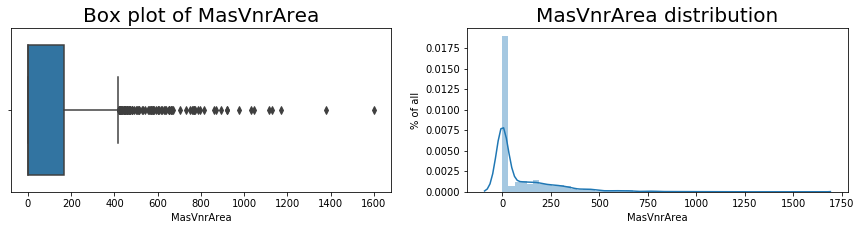

In [96]:
# checking outliers in 'MasVnrArea' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric.MasVnrArea)
plt.title('Box plot of MasVnrArea', fontsize=20)
plt.xlabel("MasVnrArea")
plt.subplot(2,2,2)
sns.distplot(data_numeric.MasVnrArea)
plt.title('MasVnrArea distribution', fontsize=20)
plt.xlabel('MasVnrArea')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

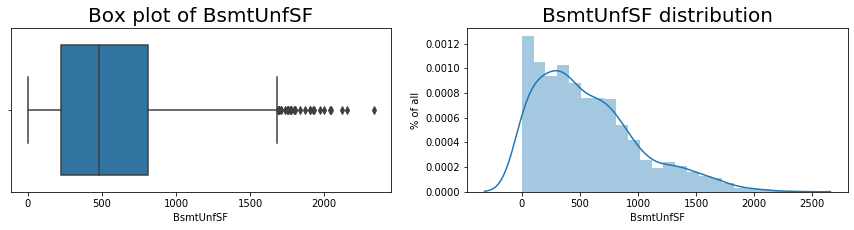

In [97]:
# checking outliers in 'BsmtUnfSF' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric.BsmtUnfSF)
plt.title('Box plot of BsmtUnfSF', fontsize=20)
plt.xlabel("BsmtUnfSF")
plt.subplot(2,2,2)
sns.distplot(data_numeric.BsmtUnfSF)
plt.title('BsmtUnfSF distribution', fontsize=20)
plt.xlabel('BsmtUnfSF')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

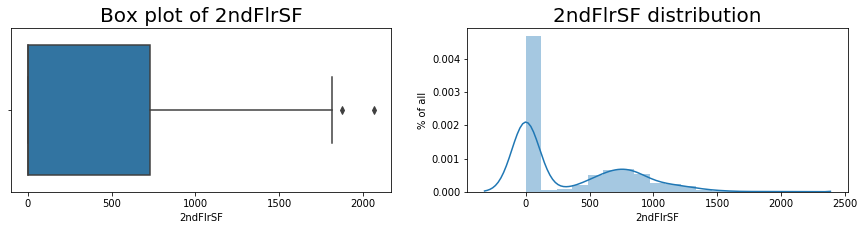

In [98]:
# checking outliers in '2ndFlrSF' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['2ndFlrSF'])
plt.title('Box plot of 2ndFlrSF', fontsize=20)
plt.xlabel("2ndFlrSF")
plt.subplot(2,2,2)
sns.distplot(data_numeric['2ndFlrSF'])
plt.title('2ndFlrSF distribution', fontsize=20)
plt.xlabel('2ndFlrSF')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

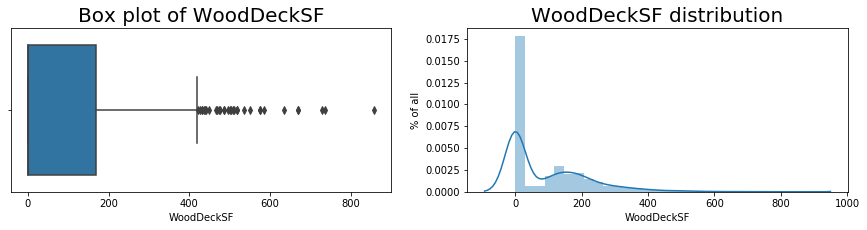

In [99]:
# checking outliers in 'WoodDeckSF' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['WoodDeckSF'])
plt.title('Box plot of WoodDeckSF', fontsize=20)
plt.xlabel("WoodDeckSF")
plt.subplot(2,2,2)
sns.distplot(data_numeric['WoodDeckSF'])
plt.title('WoodDeckSF distribution', fontsize=20)
plt.xlabel('WoodDeckSF')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

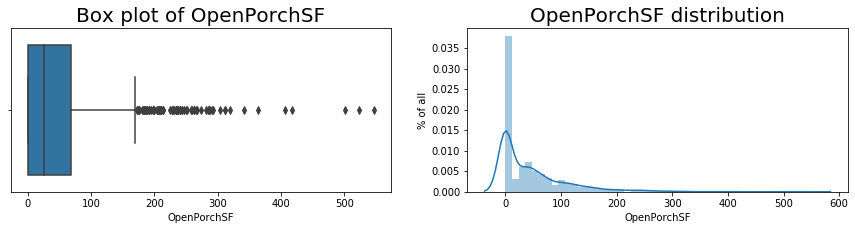

In [100]:
# checking outliers in 'OpenPorchSF' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['OpenPorchSF'])
plt.title('Box plot of OpenPorchSF', fontsize=20)
plt.xlabel("OpenPorchSF")
plt.subplot(2,2,2)
sns.distplot(data_numeric['OpenPorchSF'])
plt.title('OpenPorchSF distribution', fontsize=20)
plt.xlabel('OpenPorchSF')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

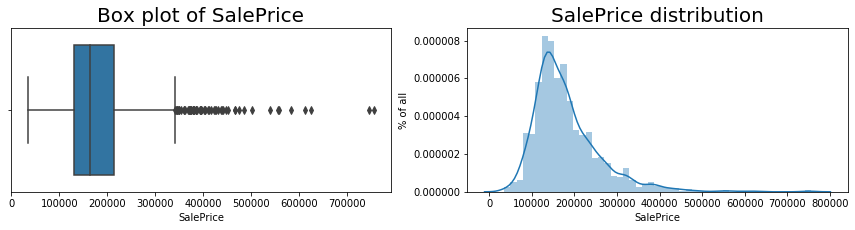

In [101]:
# checking outliers in 'SalePrice' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['SalePrice'])
plt.title('Box plot of SalePrice', fontsize=20)
plt.xlabel("SalePrice")
plt.subplot(2,2,2)
sns.distplot(data_numeric['SalePrice'])
plt.title('SalePrice distribution', fontsize=20)
plt.xlabel('SalePrice')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

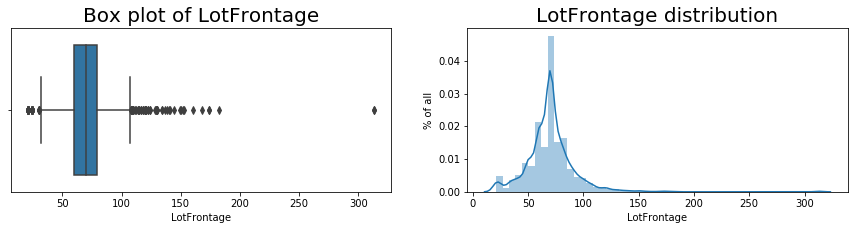

In [102]:
# checking outliers in 'LotFrontage' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['LotFrontage'])
plt.title('Box plot of LotFrontage', fontsize=20)
plt.xlabel("LotFrontage")
plt.subplot(2,2,2)
sns.distplot(data_numeric['LotFrontage'])
plt.title('LotFrontage distribution', fontsize=20)
plt.xlabel('LotFrontage')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

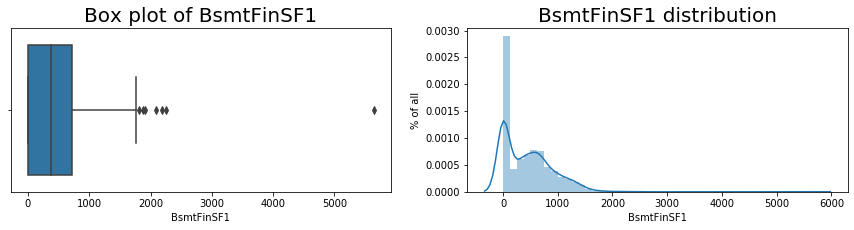

In [103]:
# checking outliers in 'BsmtFinSF1' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['BsmtFinSF1'])
plt.title('Box plot of BsmtFinSF1', fontsize=20)
plt.xlabel("BsmtFinSF1")
plt.subplot(2,2,2)
sns.distplot(data_numeric['BsmtFinSF1'])
plt.title('BsmtFinSF1 distribution', fontsize=20)
plt.xlabel('BsmtFinSF1')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

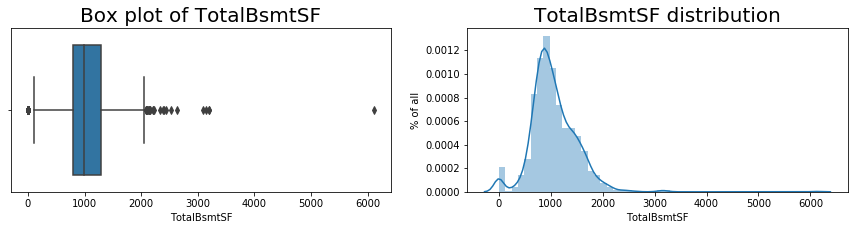

In [104]:
# checking outliers in 'TotalBsmtSF' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['TotalBsmtSF'])
plt.title('Box plot of TotalBsmtSF', fontsize=20)
plt.xlabel("TotalBsmtSF")
plt.subplot(2,2,2)
sns.distplot(data_numeric['TotalBsmtSF'])
plt.title('TotalBsmtSF distribution', fontsize=20)
plt.xlabel('TotalBsmtSF')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

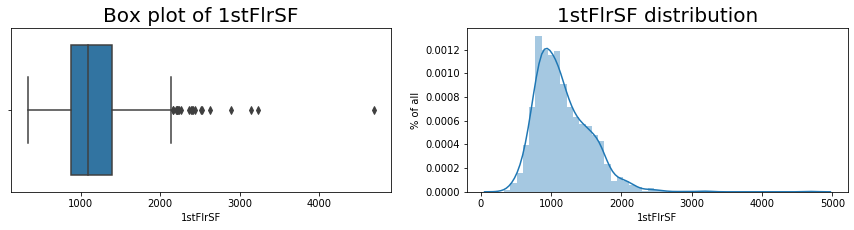

In [105]:
# checking outliers in '1stFlrSF' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['1stFlrSF'])
plt.title('Box plot of 1stFlrSF', fontsize=20)
plt.xlabel("1stFlrSF")
plt.subplot(2,2,2)
sns.distplot(data_numeric['1stFlrSF'])
plt.title('1stFlrSF distribution', fontsize=20)
plt.xlabel('1stFlrSF')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

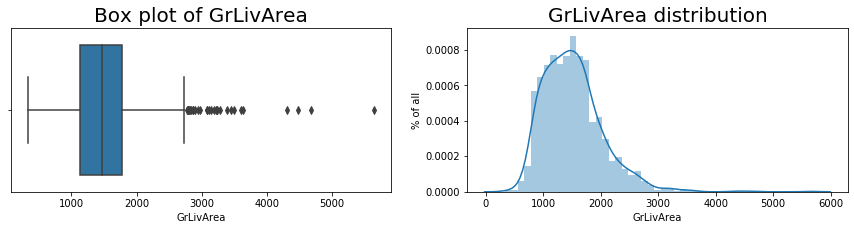

In [106]:
# checking outliers in 'GrLivArea' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['GrLivArea'])
plt.title('Box plot of GrLivArea', fontsize=20)
plt.xlabel("GrLivArea")
plt.subplot(2,2,2)
sns.distplot(data_numeric['GrLivArea'])
plt.title('GrLivArea distribution', fontsize=20)
plt.xlabel('GrLivArea')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

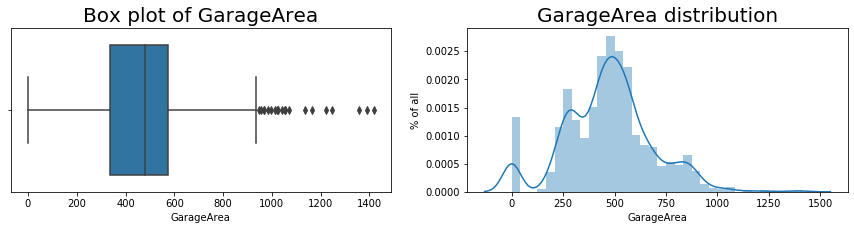

In [107]:
# checking outliers in 'GarageArea' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(data_numeric['GarageArea'])
plt.title('Box plot of GarageArea', fontsize=20)
plt.xlabel("GarageArea")
plt.subplot(2,2,2)
sns.distplot(data_numeric['GarageArea'])
plt.title('GarageArea distribution', fontsize=20)
plt.xlabel('GarageArea')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

#### Z-score outliers detection
There a lot of outliers. Thus,  we need a relevant algorithm that is able to detect outliers in the each variable. For this purpose z_score_cleaning_all algorithm was written.

In [108]:
def z_score_cleaning_all(df):
    outliers = []
    list_of_outliers = []
    #ban_list consists of the columns that are not suitable for z-score analysis
    ban_list = ['BsmtFinSF2','LowQualFinSF','BsmtFullBath','BsmtHalfBath','HalfBath','Fireplaces','EnclosedPorch','3SsnPorch','ScreenPorch',
'PoolArea','MiscVal','Month', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'OverallCond', 'YearBuilt',
 'YearRemodAdd', 'GarageQual', 'GarageCond', 'Year', 'Day', 'index', 'OverallQual', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt','GarageCars']
    for col in range(len(df.columns)):
        std = df.iloc[:,col].std()
        mean = df.iloc[:,col].mean()
        if df.columns[col] not in ban_list:
            for i in range(len(df.iloc[:,col])):
                if abs((df.iloc[i,col]-mean))/std>3:
                    list_of_outliers.append(i)
            
#return unique values only            
            uniq_l = []
            for i in list_of_outliers:
                if i not in uniq_l:
                    uniq_l.append(i+1)
        
#buble sort
            for i in range(len(uniq_l)):
                for j in range(len(uniq_l)-1):
                    if uniq_l[j] > uniq_l[j+1]:
                        uniq_l[j], uniq_l[j+1] =  uniq_l[j+1], uniq_l[j]
    #outliers = np.array(list_of_outliers)
    return uniq_l

In [109]:
# list with detected outliers
list_out = z_score_cleaning_all(data_numeric)

In [110]:
# dropping outliers
data_numeric = data_numeric.drop(list_out)

### 2.2.2. Checking logic of the numeric data

The data contains information about different parameters of area. This is logical to check whether lot area always bigger than other parameters.

In [111]:
# creating list with necessary data
def checking_area_list(data):
    list_for_checking = []
    
    bench_list = ["SF", "Area", "Enclosed"]
    for i in data.columns:
        for bench in bench_list:
            if bench in i:
                list_for_checking.append(i)
    #delete the first column, because it's a benchmark value            
    return list_for_checking[1:]

In [112]:
list_area_check=checking_area_list(data_numeric)

In [113]:
def check_ar(data, bench, list_to_check):
    for i in list_to_check:
        data[bench+' '+i] = np.where(data[bench] < data[i], 'True', 'False')
    return data

In [114]:
expended_data = check_ar(data_numeric, 'LotArea', list_area_check)

In [115]:
st = []
count = []
for i in expended_data.iloc[:,-14:].columns:
    st = list(expended_data.loc[:,i])
    count.append(len(np.where(st)[0]))

In [118]:
count == [1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341]

True

In [120]:
data_numeric = data_numeric.drop(data_numeric.columns[-14:], axis=1)

Thus, there is no an area that is bigger than lot area.

### 1.3 Merging 2 DFs
Now it's necessary to merge categorical and numerical data sets into the one dataframe.

In [121]:
merged_data = pd.merge(data_numeric, data_categorical, how='left', on='ind')

In [122]:
merged_data = merged_data.dropna()

In [123]:
merged_data = merged_data.reset_index(drop=True)

In [124]:
merged_data = merged_data.drop('ind', axis=1)

In [125]:
merged_data = pd.get_dummies(merged_data, columns=data_categorical.drop('ind', axis=1).columns)

In [126]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335 entries, 0 to 1334
Columns: 467 entries, LotFrontage to SaleCondition_Partial_1
dtypes: float64(3), int64(42), uint8(422)
memory usage: 1019.6 KB


### 1.4 Check importance of the variables

Data frame includes 467 columns now, but not all of them deliver important contribution to the prediction model. Thus, it's logical to check importance of the features in the data frame and drop not useful variables.

In [128]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [129]:
X_train = merged_data.loc[1:].drop('SalePrice', axis=1)
y_train = merged_data.loc[1:].SalePrice

In [130]:
# import modules for work
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Here it's logical to implement SelectKBest algorithm with chi2 that can return requred number of features. Say it will be 19 features.

In [162]:
#Let's create a new df with the k-highest rang
X_new = SelectKBest(chi2, k=19).fit_transform(X_train, y_train)
X_new.shape

(1334, 19)

But for the further work with test samples it's important to know which columns were chosen. Let's implement code below to understand that.

In [163]:
# Create and fit selector
selector = SelectKBest(chi2, k=19)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)

Before we start building models, let's check what the ranking of the importance of variables will be generated by the Random Forest algorithm.

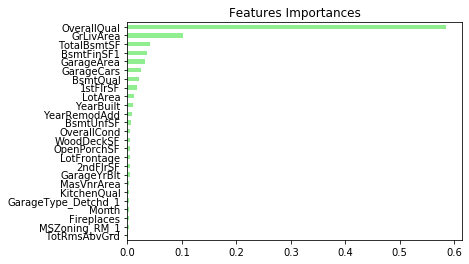

In [164]:
### CHECKING IMPORTANT FEATURES

# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train) 

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()
importances_sorted = importances_sorted

# Draw a horizontal barplot of importances_sorted
importances_sorted.tail(25).plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()# Create a pd.Series of features importances

Let's append 'OverallQual' variable to the current list of the selected features.

In [165]:
cols = np.append(cols, merged_data.drop('SalePrice', axis=1).columns.get_loc('OverallQual'))

In [166]:
important_cols = merged_data.drop('SalePrice', axis=1).iloc[:,cols].columns

In [167]:
important_cols

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'OverallQual'],
      dtype='object')

In [168]:
X_new_1=merged_data[important_cols]
X_new_1 = X_new_1[1:]
X_new_1.shape

(1334, 20)

# Build a prediction model

Let's start with the simplest one - linear regression model

In [169]:
### Linear regression ###


# Import necessary modules
from sklearn import linear_model
from sklearn.model_selection import cross_val_score


Linear_reg = linear_model.LinearRegression()

LR_scores = cross_val_score(
        Linear_reg, X_new_1, y_train,
        cv=5)

LR_scores.mean()


0.8267708034690848

Not bad, but let's check more sophisticated models.

In [170]:
### KNN with a number of neighbors tuning ###


# Import necessary modules
from sklearn.neighbors import KNeighborsRegressor


# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsRegressor())]

pipeline_knn = Pipeline(steps)



# Setup the hyperparameter grid
param_grid = {'knn__n_neighbors': np.array(range(1,20))}

# Instantiate the GridSearchCV object: knn_cv
knn_cv = GridSearchCV(pipeline_knn, param_grid, cv=5)

# Fit it to the data
knn_cv.fit(X_new_1, y_train)  ######Better  use training data, not whole data

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_))

Tuned Logistic Regression Parameters: {'knn__n_neighbors': 15}
Best score is 0.7806676736672012


In [171]:
# Import necessary modules
from sklearn.tree import DecisionTreeRegressor 

# Setup the parameters and distributions to sample from: param_dist - _just a list of parametrs to check_
param_dist = {"max_depth": [3, None],
              "max_features": np.array(range(1,7)),
              "min_samples_leaf": np.array(range(1,7))}

# Instantiate a Decision Tree Regressor: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data

tree_cv.fit(X_new_1,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 5}
Best score is 0.74059724211938


In [174]:
from sklearn.ensemble import RandomForestRegressor

### Define the dictionary 'params_rf'
params_rf = {
    'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 500, num = 4)],
    'max_features':['log2','auto','sqrt'],
    'max_depth' : np.array(range(1,7)),
    'min_samples_leaf':[int(x) for x in np.linspace(start = 1, stop = 10, num = 4)]}



### Setup a model
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       cv=3)

grid_rf.fit(X_new_1, y_train)


print("Tuned Decision Tree Parameters: {}".format(grid_rf.best_params_))
print("Best score is {}".format(grid_rf.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 500}
Best score is 0.8407217635500137


In [177]:
### Set up AdaBoostClassifier

# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

# Parametrs for griding
param_grid = {
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }


# Instantiate dt
dt = DecisionTreeRegressor(max_depth= None, max_features=5, min_samples_leaf=6)

# Instantiate ada
ada = AdaBoostRegressor(base_estimator=dt)


grid_ada = GridSearchCV(estimator=ada,
                       param_grid=param_grid,
                       cv=3)

### Fitting the model and predicting probability of their decisions
# Fit ada to the training set
grid_ada.fit(X_new_1, y_train)



# Compute and print metrics
print("Tuned Model Parameters: {}".format(grid_ada.best_params_))
print("Best score is {}".format(grid_ada.best_score_))

Tuned Model Parameters: {'base_estimator__splitter': 'best', 'n_estimators': 1}
Best score is 0.7064298861946131


In [173]:
import xgboost as xgb
from sklearn import preprocessing

xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_new_1,
         y_train)

print("Tuned Model Parameters: {}".format(xgb_grid.best_params_))
print("Best score is {}".format(xgb_grid.best_score_))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   16.6s finished


[18:11:27] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[18:11:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:11:28] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
Tuned Model Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
Best score is 0.847823437568618


# Compare results
Now it's possible to compare how accurate models were

In [178]:
models_score = ({
    'AdaBoost' : grid_ada.best_score_,
    'Linear Regression' : LR_scores.mean(),
'Random Forest' : grid_rf.best_score_,
'Desicion tree': tree_cv.best_score_,
'KNN': knn_cv.best_score_,
'Xgboost': xgb_grid.best_score_})
models_score = pd.Series(models_score).to_frame('Model_score')
models_score = pd.DataFrame(models_score).reset_index()
models_score.rename(columns={'index':'Model_name'}, inplace=True)
models_score.sort_values(by='Model_score', inplace=True, ascending=False)

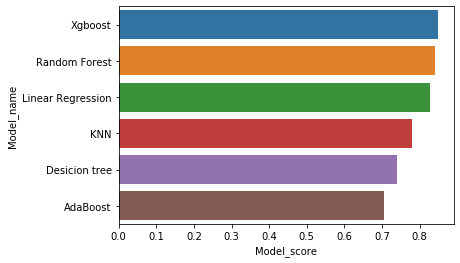

In [179]:
sns.barplot(x='Model_score',y='Model_name', data=models_score)
plt.show()

The winner is the Xgboost algorithm, let's implement it to the test data set.

# Prediction

In [190]:
path = '/Users/anatolyabramovich/Desktop/Documents/Study/Kaggle/house_pricing/test.csv'
data_test = pd.read_csv(path, index_col='Id')

In [209]:
X_test = data_test.loc[1:,important_cols]

In [210]:
xgb_grid.predict(X_test)

array([133274.88, 172900.64, 173737.81, ..., 174029.9 , 109081.01,
       241211.42], dtype=float32)

In [211]:
prediction_xgb = xgb_grid.predict(X_test)
xgb_prediction = pd.Series(prediction_xgb, index= list(range(1461,2920))).to_frame('SalePrice')
xgb_prediction.index.name= 'Id'
xgb_prediction.to_csv('/Users/anatolyabramovich/Desktop/Documents/Study/Kaggle/house_pricing/xgb_prediction.csv')

Final result - 0.16004 Root Mean Squared Logaritmic error.
A lot of space to improve.